# Tangle density detection using combination of ResNet-18 and WildCat

In [1]:
# Prelims
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import openslide

# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1
CUDA status:  True
CUDA memory max alloc:        0 MB


In [2]:
# Global properties
num_classes=2
input_size=224
input_size_wildcat=448
batch_size=8
batch_size_wildcat=8
resnet_flavor=18
data_dir = "/home/pyushkevich/data/twoway"

## Load the two models

In [3]:
# Read the ResNet model
if resnet_flavor == 50:
    model_resnet = models.resnet50(pretrained=False)
    model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
    model_resnet.load_state_dict(torch.load('my_resnet_50_200epoch.dat'))
else:
    model_resnet = models.resnet18(pretrained=False)
    model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
    model_resnet.load_state_dict(torch.load('my_resnet_200epoch.dat'))
    
model_resnet.eval()

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

In [4]:
# Read the wildcat model
model_wildcat = wildcat.models.resnet50_wildcat(2, pretrained=False, kmax=0.2, alpha=0.7, num_maps=4)
model_wildcat.load_state_dict(torch.load('/home/pyushkevich/resnet/my_wildcat_50_30epoch_k02_448.dat'))

# Set evaluation mode
model_wildcat.eval()

# Send model to GPU
model_wildcat = model_wildcat.to(device)

## Process OpenSlide

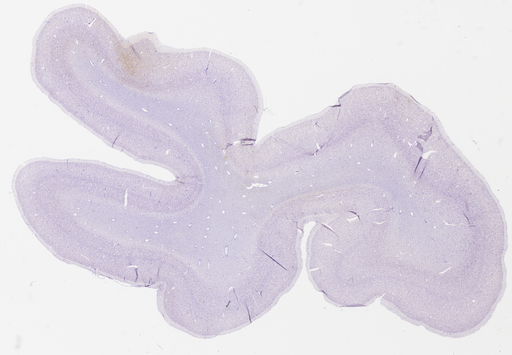

In [5]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide('/home/pyushkevich/285342.svs')
osl.get_thumbnail((512,512))

In [6]:
# The step by which the sampling window is slid (in raw pixels)
stride = 100

# Window size in strides (e.g., 400 pixels)
window_size=4

# Desired number of windows per chunk of SVS loaded into memory at once
chunk_size=40

# Actual chunk size (without overhang)
chunk_width=stride * chunk_size

# Dimensions of the input image
slide_dim = np.array(osl.dimensions)

# Scaling factor for output pixels, how many output pixels for every wildcat
# output pixel. This is needed because for stride of 100, there would be a 
# non-integer number of output pixels (14/4). 
out_scale = 2

# Size of output pixel (in input pixels)
out_pix_size = 32 * window_size * stride / (input_size_wildcat * out_scale)

# Output image size 
out_dim=(slide_dim/out_pix_size).astype(int)

# Output array (last dimension is per-class probabilities)
density=np.zeros((2, out_dim[0], out_dim[1]))

# Range of pixels to scan
# u_range,v_range = (40000,50000),(25000,35000)
u_range,v_range = (0,slide_dim[0]),(0,slide_dim[1])

# Range over u and v
for u in range(u_range[0], u_range[1], chunk_width):
    for v in range(v_range[0], v_range[1], chunk_width):
       
        # Get the width of the region currently covered
        win_dim = np.array((min(u_range[1] - u, chunk_width), min(v_range[1] - v, chunk_width)))
        
        # Add the overhang - this is what will be read from the image
        win_dim_ohang = win_dim + (window_size-1) * stride
        
        # Read the chunk from the image
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((u,v), 0, win_dim_ohang).convert("RGB")
        t1 = timeit.default_timer()

        # Resample the chunk for the two networks
        win_dim_ohang_resnet = win_dim_ohang * input_size / (stride * window_size)        
        tran_resnet = transforms.Compose([
            transforms.Resize(int(min(win_dim_ohang_resnet))),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Stride width for resnet (1/4 of 224)
        stride_t = int(input_size / window_size)
        
        # Convert the read chunk to tensor format
        chunk_tensor=tran_resnet(chunk_img).to(device)
        chunk_ufold=chunk_tensor.unfold(1,input_size,stride_t).unfold(2,input_size,stride_t).permute((1,2,0,3,4))
        
        # Create array of windows that are hits
        hits=[]
        
        # Iterate over windows
        for i in range(0, chunk_ufold.shape[1]):
            for k in range(0, chunk_ufold.shape[0], batch_size):
                
                # Process the batch
                k_range = range(k,min(k+batch_size, chunk_ufold.shape[0]))
                y_ik = model_resnet(chunk_ufold[k_range,i,:,:,:]).cpu().detach().numpy()
                
                # Record all the hits in this batch
                for j in k_range:
                    if np.argmax(y_ik[j-k,:]) > 0:
                        hits.append([i, j])
                        print("Hit: ", (u + stride * i, v + stride * j), " y = ", y_ik[j-k,:])
                        
        # Finished first pass through the chunk
        t2 = timeit.default_timer()
        
        # If there are hits, perform wildcat refinement
        if len(hits) > 0:
            
            # Resample the chunk for the wildcat network
            win_dim_ohang_wildcat = win_dim_ohang * input_size_wildcat / (stride * window_size)        
            tran_wildcat = transforms.Compose([
                transforms.Resize(int(min(win_dim_ohang_wildcat))),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
            # Stride width for resnet (1/4 of 448)
            stride_t_wildcat = int(input_size_wildcat / window_size)
            
            # Convert the read chunk to tensor format and unfold
            chunk_tensor_wildcat=tran_wildcat(chunk_img).to(device)
            chunk_ufold_wildcat=chunk_tensor_wildcat.unfold(
                1,input_size_wildcat,stride_t_wildcat).unfold(
                2,input_size_wildcat,stride_t_wildcat).permute((1,2,0,3,4))
            
            # Stack the tensors
            hit_folds=[]
            for h in hits:
                hit_folds.append(chunk_ufold_wildcat[h[1],h[0],:,:,:])
                
            hit_sausage=torch.stack(hit_folds)
            
            # Process by batches
            for j in range(0, len(hits), batch_size_wildcat):
                j_end = min(j+batch_size_wildcat, len(hits))
                
                # Forward pass through the wildcat model
                x_feat = model_wildcat.features(hit_sausage[j:j_end,:,:,:])
                x_clas = model_wildcat.classifier(x_feat)
                x_cpool = model_wildcat.spatial_pooling.class_wise(x_clas)

                # Scale the cpool image
                x_cpool_up = torch.nn.functional.interpolate(x_cpool, scale_factor=out_scale)
                w = x_cpool_up.shape[3]
                
                # Output index for the current hit
                for m in range (j, j_end):
                    u_out = round((u + stride * hits[m][0]) / out_pix_size)
                    v_out = round((v + stride * hits[m][1]) / out_pix_size)
                    density[0, u_out:u_out+w,v_out:v_out+w] += x_cpool_up[m-j,0,:,:].detach().cpu().numpy().transpose()
                    density[1, u_out:u_out+w,v_out:v_out+w] += x_cpool_up[m-j,1,:,:].detach().cpu().numpy().transpose()
                
        # Finished first pass through the chunk
        t3 = timeit.default_timer()
        
        # At this point we have a list of hits for this chunk
        print("Chunk: (%6d,%6d) Hits: %4d Times: IO=%6.4f ResN=%6.4f WldC=%6.4f Totl=%8.4f" %
              (u,v,len(hits),t1-t0,t2-t1,t3-t2,t3-t0))

Chunk: (     0,     0) Hits:    0 Times: IO=2.4183 ResN=1.9314 WldC=0.0000 Totl=  4.3497
Chunk: (     0,  4000) Hits:    0 Times: IO=1.0341 ResN=1.4620 WldC=0.0000 Totl=  2.4961
Chunk: (     0,  8000) Hits:    0 Times: IO=0.9425 ResN=1.5545 WldC=0.0000 Totl=  2.4969
Chunk: (     0, 12000) Hits:    0 Times: IO=0.9552 ResN=1.5141 WldC=0.0000 Totl=  2.4692
Chunk: (     0, 16000) Hits:    0 Times: IO=0.9522 ResN=1.5602 WldC=0.0000 Totl=  2.5124
Chunk: (     0, 20000) Hits:    0 Times: IO=0.9624 ResN=1.5131 WldC=0.0000 Totl=  2.4755
Hit:  (2900, 27700)  y =  [-0.45679322  0.3986142 ]
Hit:  (3000, 27600)  y =  [-0.8787581   0.94619685]
Hit:  (3000, 27700)  y =  [-2.5740058  2.5422208]
Hit:  (3000, 27800)  y =  [-1.2085518  1.4682117]
Hit:  (3100, 27700)  y =  [-0.5453899  0.5889914]
Hit:  (3700, 27200)  y =  [-0.4995769  1.1001912]
Hit:  (3700, 27300)  y =  [0.1223925 0.4293149]
Hit:  (3800, 27200)  y =  [0.12392282 0.44388542]
Hit:  (3800, 27300)  y =  [0.26787952 0.40113002]
Chunk: (     0

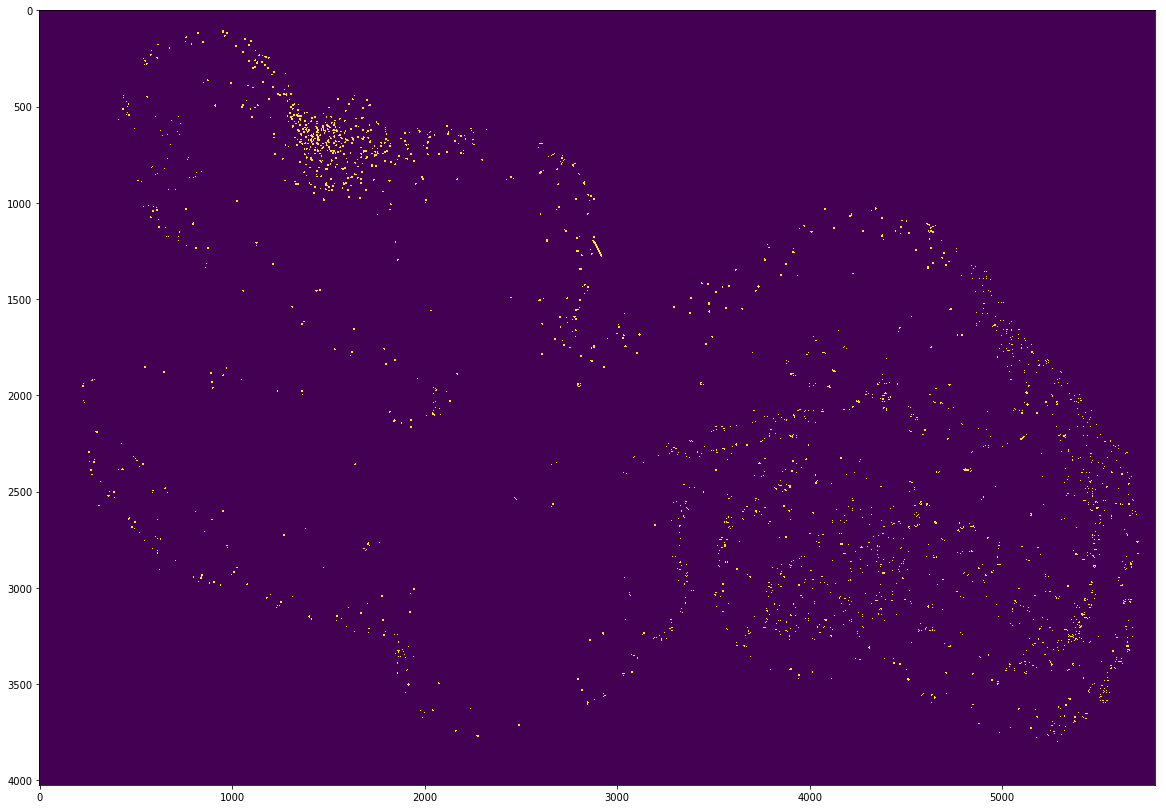

In [7]:
our=np.array(u_range) / out_pix_size
ovr=np.array(v_range) / out_pix_size

plt.figure(figsize=(20,20))
plt.imshow(density[1,int(our[0]):int(our[1]),int(ovr[0]):int(ovr[1])].transpose() > density[0,int(our[0]):int(our[1]),int(ovr[0]):int(ovr[1])].transpose())

In [8]:
# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample,vrange=(-1000,1000)):
    # The image region
    img_rgn=osl.read_region((u0,v0), d_sample,
                            (int((u1-u0)/osl.level_downsamples[d_sample]),
                             int((v1-v0)/osl.level_downsamples[d_sample])))
    
    # The tangle map
    o_u0 = int(u0 / out_pix_size)
    o_v0 = int(v0 / out_pix_size)
    o_u1 = int(u1 / out_pix_size)
    o_v1 = int(v1 / out_pix_size)
    t_map=density[1,o_u0:o_u1,o_v0:o_v1].transpose()-density[0,o_u0:o_u1,o_v0:o_v1].transpose()
    t_map=np.where(t_map > 0, t_map, 0)
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=vrange[0], vmax=vrange[1], extent=(u0,u1,v1,v0))
    # ax[1].colorbar(cs)
    fig.show()

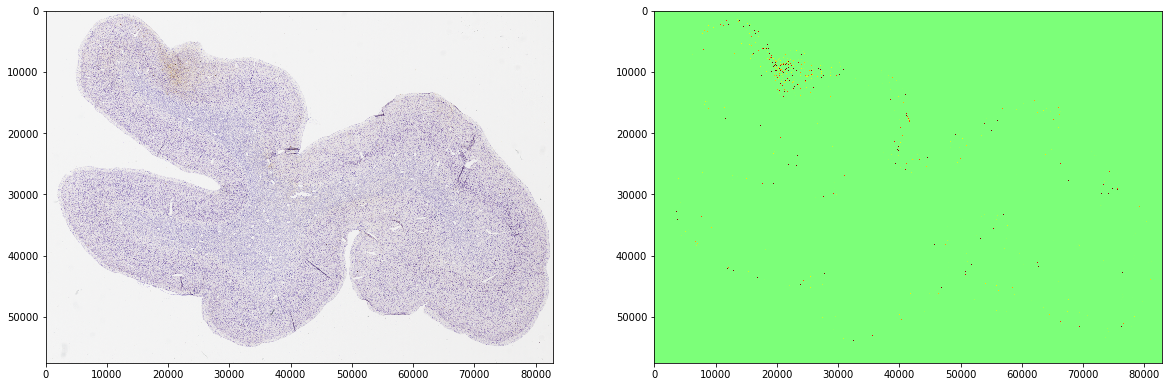

In [9]:
plot_classification_region(u_range[0],v_range[0],u_range[1],v_range[1],3)


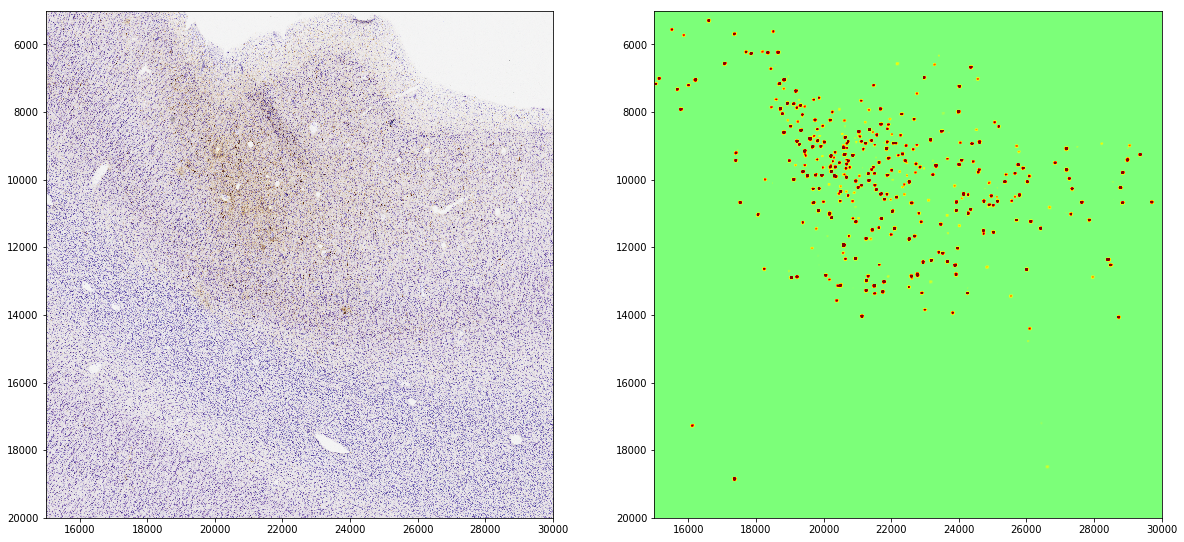

In [10]:
plot_classification_region(15000,5000,30000,20000,1)

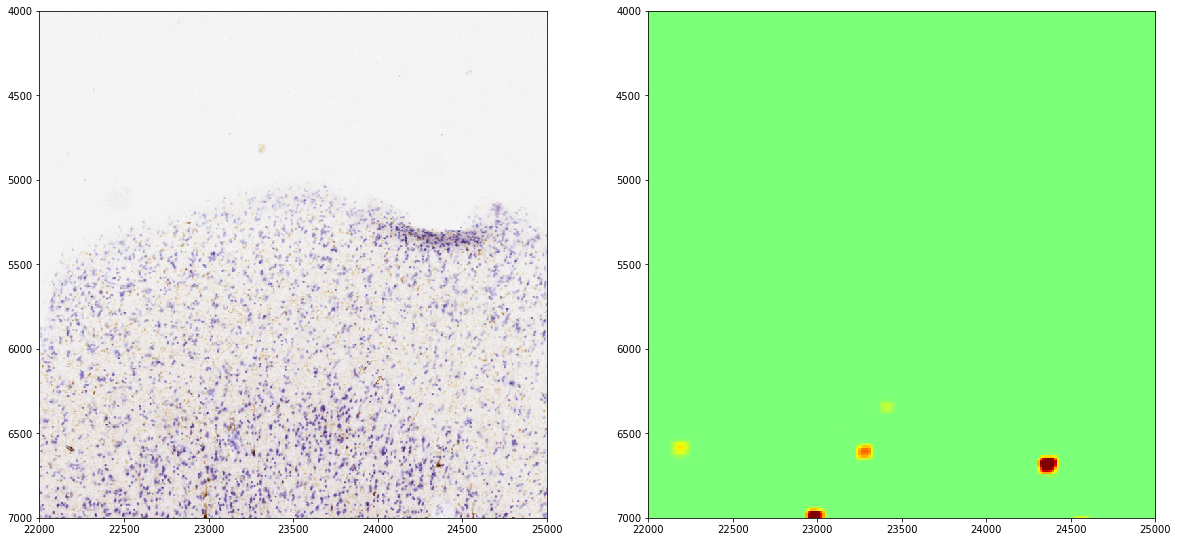

In [11]:
plot_classification_region(22000,4000,25000,7000,1)

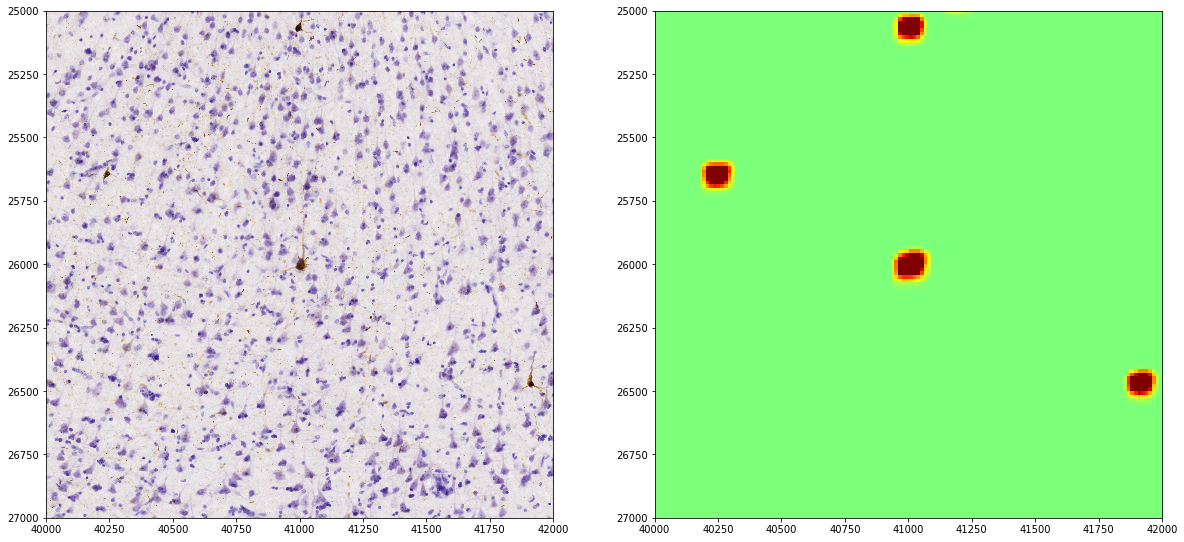

In [12]:
plot_classification_region(40000,25000,42000,27000,0)

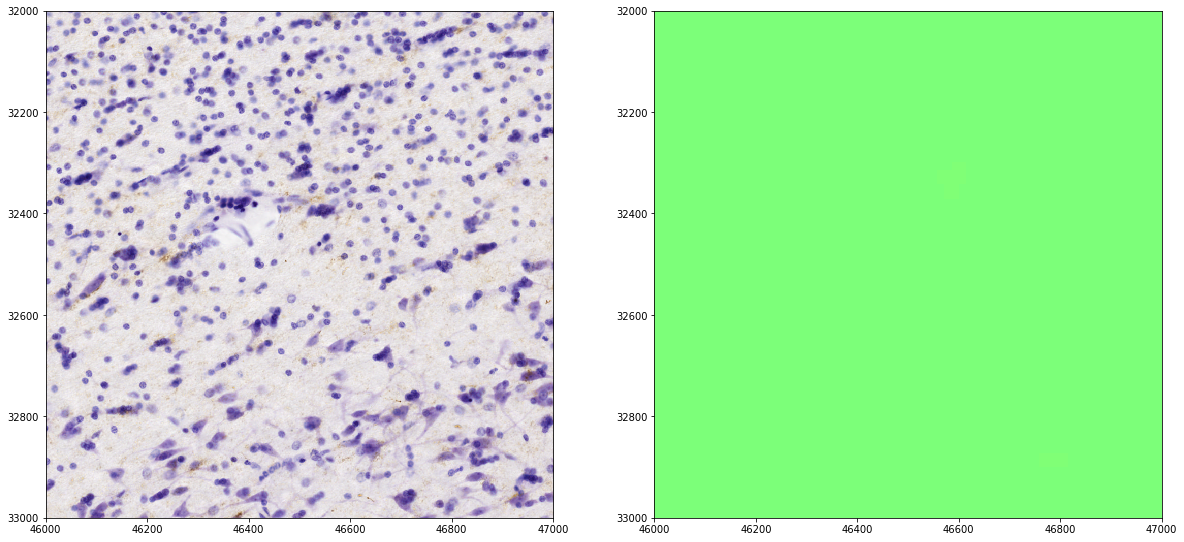

In [146]:
plot_classification_region(46000,32000,47000,33000,0)
